In [114]:
import dolfin as dl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

np.random.seed(2)

# Create the Network

In [134]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 1)
        self.apply(self._init_weights)
        
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
        self.fc2.weight.requires_grad = True
        self.fc2.bias.requires_grad = True
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.uniform_()
            if module.bias is not None:
                module.bias.data.zero_()

        
    def forward(self, x):
        x = torch.tensor([x])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.item()
    
    def vector_eval(self, x, m):
        
        if type(x) is not list:
            x = x.tolist()
        
        i = 0
        for xi in x:
            m[i] = self.forward(xi)
            i += 1

# Testing model

In [95]:
model = NN()
x = [1.,2.]
m = [1.,2.]
model.vector_eval(x,m)
print(m)
print(model.state_dict())

[0.8073497414588928, 1.6146994829177856]
OrderedDict([('fc1.weight', tensor([[0.3596],
        [0.1925],
        [0.8592]])), ('fc1.bias', tensor([0., 0., 0.])), ('fc2.weight', tensor([[0.1043, 0.7986, 0.7171]])), ('fc2.bias', tensor([0.]))])


# Set device

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating component needed for model

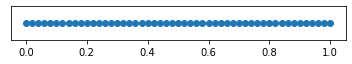

In [20]:
# number of elements for training and testing data
n_train = 50
n_test  = 101

# Create mesh for training and testing data
mesh_train = dl.UnitIntervalMesh(n_train)
mesh_test = dl.UnitIntervalMesh(n_test)

# Create vector version of mesh
mesh_vec = np.linspace(0,1,n_train)

# Define the function space
Vh = dl.FunctionSpace(mesh_train, 'Lagrange', 1)

# Show the mesh
dl.plot(mesh_train)
plt.show()


# Boundary information

In [21]:
def ud_boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
ud = dl.Constant('0.0')
bc = dl.DirichletBC(Vh, ud, ud_boundary)



# FEM model


In [128]:
class FEM_function:
    def __init__(self, Vh, mesh, bc):
        self.Vh = Vh
        self.coords = np.array(mesh_train.coordinates()).tolist()
        self.bc = bc
        
        # Define variational problem
        self.uh = dl.TrialFunction(Vh)
        self.vh = dl.TestFunction(Vh)
        self.M = dl.assemble( dl.inner(self.uh, self.vh)*dl.dx(self.Vh) )
        
        self.m_vector = dl.Vector()
        self.u = dl.Vector()
        self.p = dl.Vector()
        self.M.init_vector(self.m_vector, 0)
        self.M.init_vector(self.u, 0)
        self.M.init_vector(self.p, 0)
        
        self.ud = None
        self.m_fun = None
        
    def forward_data(self, m, f_expr, noise_lvl, add_noise = False):
        Kform = m * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        K, self.f = dl.assemble_system(Kform, f_expr*self.vh*dl.dx(self.Vh), self.bc)
        solver = dl.LUSolver()
        solver.set_operator(K)
        
        solver.solve(self.u, self.f)
        
        self.ud = dl.Vector()
        self.M.init_vector(self.ud, 0)        
        self.ud.axpy(1.,self.u)
        
        if add_noise is True:
            uL2 = dl.norm(self.u, 'L2')
            noise = dl.Vector()
            M.init_vector(noise, 0)   
            noise.set_local( noise_lvl * uL2 *np.random.randn(Vh.dim()))
            self.ud.axpy(1.,noise)
        
        return self.u, self.ud
    
    def extract_m(self, model):
        model.vector_eval(self.coords,self.m_vector)
        return dl.Function(self.Vh, self.m_vector)

    def update_Systems(self, model):
        self.m_fun = self.extract_m(model)
        Kform   = self.m_fun * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        Kformt  = self.m_fun * dl.inner(dl.grad(self.vh), dl.grad(self.uh))*dl.dx(self.Vh)
        
        self.K, _ = dl.assemble_system(Kform, dl.Constant(0.)*self.vh*dl.dx(self.Vh), self.bc)
        self.Kt, _ = dl.assemble_system(Kformt, dl.Constant(0.)*self.vh*dl.dx(self.Vh), self.bc)
        
        self.solver = dl.LUSolver()
        self.solver.set_operator(self.K)
        self.solvert = dl.LUSolver()
        self.solvert.set_operator(self.Kt)
       
    def forward(self, model):
        self.update_Systems(model)
        
        self.solver.solve(self.u,self.f)
        
        return torch.from_numpy(self.u.get_local())
        
    def adjoint(self):
        
        rhs = dl.Vector()
        self.M.init_vector(rhs, 0)
        rhs.axpy(-1., self.M * (self.u - self.ud))
        
        self.solver.solve(self.p, rhs)
        
        return self.p
    
    def cost(self, model):
        c = 0
        _ = self.forward(model)
        
        c = .5 * np.inner(self.M * (self.u - self.ud),(self.u - self.ud))
        
        return c
    
    def grad(self, model):
        _ = self.forward(model)
        _ = self.adjoint()
        
        u_fun = dl.Function(self.Vh, self.u)
        Fm = dl.assemble(dl.inner(dl.grad(u_fun), dl.grad(self.vh))*dl.dx(self.Vh))
        Jm = dl.assemble(dl.inner(dl.Constant(0.), dl.Constant(0.))*dl.dx(self.Vh))
        
        return (np.inner(self.p, Fm) + Jm)

# Create data

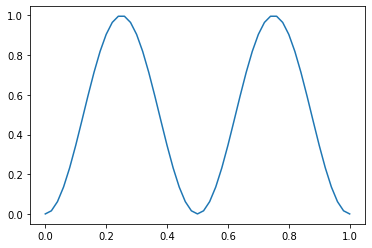

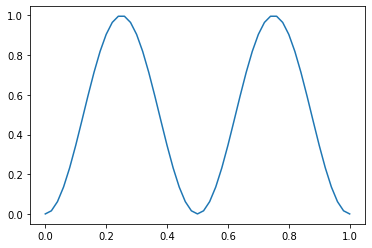

In [159]:
noise_lvl = 0.02

# True m
m_true = dl.Constant(1.)
mx = dl.Constant(0.0)

# True solution and derivatives
utrue = dl.Expression('sin(2*pi*x[0]) * sin(2*pi*x[0])', degree=3)
ux = dl.Expression('4 * pi * sin(2*pi*x[0]) * cos(2*pi*x[0])', degree=3)
uxx = dl.Expression('-8*pi*pi*( sin(2*pi*x[0]) * sin(2*pi*x[0]) - cos(2*pi*x[0]) * cos(2*pi*x[0]) )', degree=3)

f = -mx*ux - m_true*uxx

FEM_model = FEM_function(Vh, mesh = mesh_train, bc = bc)

uapprox, data = FEM_model.forward_data(m_true, f, noise_lvl, add_noise=False)
# data = torch.from_numpy(data.get_local())
uapprox = dl.Function(Vh, uapprox)
data = dl.Function(Vh, data)

dl.plot(uapprox)
plt.show()
dl.plot(data)
plt.show()



In [135]:
# Create an instance of the network
model = NN()


# Loss and optimizer

In [131]:
learning_rate = 0.001

# Define the loss function
def loss_fn(output, target):
    return .5 * torch.mean((output - target) ** 2)

def grad_fn(FEM_model,NN):
    dj = FEM_model.grad(NN)
    gradients = []
    for p in NN.parameters():
        gradients.append(p.grad.view(-1).numpy())
        
    return dj*gradients

optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train model

In [156]:
# Define the training loop
def train(params):
    # Update the neural network weights
    with torch.no_grad():
        net_params = torch.tensor(params, dtype=torch.float32).reshape(-1, 1)
        current_param_idx = 0
        for p in model.parameters():
            p.data = net_params[current_param_idx:current_param_idx+p.numel()].reshape(p.shape)
            current_param_idx += p.numel()
        
    print(model.fc1.weight.grad)
    # Compute the predictions and loss
    y_pred = FEM_model.forward(model)
    y_pred = Variable(y_pred.data, requires_grad=True)
    loss = loss_fn(y_pred, data)
    # Compute the gradients and update the weights
    model.zero_grad()
    loss.backward()
    print(model.fc1.weight.grad)
    grads = grad_fn(FEM_model,model)
    grads = grads.astype('float64') # convert to the correct data type
    return loss.item(), grads

# Define the optimizer
def optimize(params):
    loss, grads = train(params)
    return loss, grads



In [157]:
# Initialize the weight parameter and optimize it with scipy
params0 = np.concatenate([p.view(-1).detach().numpy() for p in model.parameters()])
bounds = [(None, None)]


for epoch in range(100):
    result = minimize(optimize, params0, jac=True, method='L-BFGS-B', bounds=bounds)
    params0 = result.x

ValueError: length of x0 != length of bounds

In [158]:
print(optimize(params0))

None
None


AttributeError: 'NoneType' object has no attribute 'view'

In [146]:
num_epochs = 1

for epoch in range(num_epochs):
    
    # forward
    u_test = FEM_model.forward(model)
    u_test = Variable(u_test.data, requires_grad=True)
    
    loss = loss_fn(u_test, data)

    # backward prop
    optimizer.zero_grad()
    loss.backward()

    print(model.fc1.weight.grad)
    
    # gradient descent or adam step
    optimizer.step()
    
    if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item():.4f}')

None
Epoch 0: Loss = 2.2614


In [77]:
x = np.linspace(0,1,50)
x = x.reshape(50,1)
y = 0*x

for i in range(len(x)):
    print(x[i])
    y[i] = model(x[i].tolist())

[0.]
[0.02040816]
[0.04081633]
[0.06122449]
[0.08163265]
[0.10204082]
[0.12244898]
[0.14285714]
[0.16326531]
[0.18367347]
[0.20408163]
[0.2244898]
[0.24489796]
[0.26530612]
[0.28571429]
[0.30612245]
[0.32653061]
[0.34693878]
[0.36734694]
[0.3877551]
[0.40816327]
[0.42857143]
[0.44897959]
[0.46938776]
[0.48979592]
[0.51020408]
[0.53061224]
[0.55102041]
[0.57142857]
[0.59183673]
[0.6122449]
[0.63265306]
[0.65306122]
[0.67346939]
[0.69387755]
[0.71428571]
[0.73469388]
[0.75510204]
[0.7755102]
[0.79591837]
[0.81632653]
[0.83673469]
[0.85714286]
[0.87755102]
[0.89795918]
[0.91836735]
[0.93877551]
[0.95918367]
[0.97959184]
[1.]
